## Set up Path

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/Capstone')

## Load data from Hugging Face

In [ ]:
# !pip install datasets
from datasets import load_dataset
dataset = load_dataset("stanfordnlp/imdb")

In [ ]:
imdb_train = dataset['train']
imdb_test = dataset['test']

In [ ]:
imdb_train.to_csv("data/imdb_train.csv")

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

33322167

In [ ]:
imdb_test.to_csv("data/imdb_test.csv")

Creating CSV from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

32540147

## Preprocessing

In [ ]:
import pandas as pd
import re
from bs4 import BeautifulSoup

In [ ]:
df_train = pd.read_csv('data/imdb_train.csv')
df_test = pd.read_csv('data/imdb_test.csv')

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
from bs4 import BeautifulSoup
import re

# 移除HTML标签
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

# 移除特殊字符和数字
def remove_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)

# 转换为小写
def to_lower(text):
    return text.lower()

def preprocess_text(text):
    text = remove_html_tags(text)
    text = remove_special_characters(text)
    text = to_lower(text)
    return text

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

<ipython-input-6-455522397882>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()
<ipython-input-6-455522397882>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


## Tokenize

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def preprocess_and_tokenize(text):
    # 应用之前的预处理步骤
    text = preprocess_text(text)  # 比如转换为小写、移除特殊字符等
    # 使用 nltk 进行分词
    return word_tokenize(text)

# 应用预处理和分词
df_train['tokens'] = df_train['text'].apply(preprocess_and_tokenize)
df_test['tokens'] = df_test['text'].apply(preprocess_and_tokenize)


In [ ]:
from collections import Counter

# 构建词汇表
all_tokens = [token for sublist in df_train['tokens'] for token in sublist]
vocab = Counter(all_tokens)
# 只保留出现至少两次的词
vocab = {word: idx+2 for idx, (word, freq) in enumerate(vocab.items()) if freq >= 2}
vocab['<unk>'] = 1
vocab['<pad>'] = 0

# 编码函数
def encode(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# 应用编码
df_train['encoded'] = df_train['tokens'].apply(lambda tokens: encode(tokens, vocab))
df_test['encoded'] = df_test['text'].apply(lambda tokens: encode(tokens, vocab))



In [ ]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(df_train, test_size=0.1, random_state=42)


确定padding的长度

In [ ]:
# 分析文档长度分布
lengths = [len(tokenizer(text)) for text in df_train['text']]
lengths.sort()

# 确定一个覆盖95%数据的序列长度
fixed_length = lengths[int(len(lengths) * 0.95)]

# 查看结果
print(f"Selected fixed length for padding/truncating: {fixed_length}")


NameError: name 'tokenizer' is not defined

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class IMDBDataset(Dataset):
    def __init__(self, dataframe, max_length):
        self.data = dataframe
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = row['label']
        encoded = row['encoded'][:self.max_length] + [vocab['<pad>']] * (self.max_length - len(row['encoded']))
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# 确定序列最大长度
max_length = 500

# 创建数据集
train_dataset = IMDBDataset(train_data, max_length)
valid_dataset = IMDBDataset(valid_data, max_length)
test_dataset = IMDBDataset(df_test, max_length)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## **Seq-CNN**

In [ ]:
import torch
import torch.nn as nn
class SeqCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()

        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # 卷积层，多个不同大小的卷积核
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])

        # 池化层不需要定义，因为我们使用的是全局最大池化

        # 全连接层
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        # Dropout 层
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]

        embedded = self.embedding(text)
        # embedded = [batch size, sent len, emb dim]

        embedded = embedded.unsqueeze(1)
        # embedded = [batch size, 1, sent len, emb dim]

        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.conv_layers]
        # conv_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]

        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]

        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]

        return self.fc(cat)


In [ ]:
# 定义超参数
vocab_size = len(vocab) + 1 # 词汇表大小
embedding_dim = 100  # 嵌入层维度
n_filters = 100  # 卷积层滤波器数量
filter_sizes = [3, 4, 5]  # 卷积层滤波器尺寸
output_dim = 1  # 输出层维度
dropout = 0.5  # Dropout 比率

model = SeqCNN(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout)

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

optimizer = Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

# 将模型和损失函数移动到GPU，如果可用的话
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


In [ ]:
import torch

# 定义训练过程
def train(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for texts, labels in iterator:
        texts = texts.to(device)
        labels = labels.to(device).type(torch.float32)

        optimizer.zero_grad()

        predictions = model(texts).squeeze(1)

        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 定义评估过程
def evaluate(model, iterator, criterion, device):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0

    with torch.no_grad():
        for texts, labels in iterator:
            texts = texts.to(device)
            labels = labels.to(device).type(torch.float32)

            predictions = model(texts).squeeze(1)

            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# 准确率计算函数
def accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc


In [ ]:
# 定义epochs和存储性能指标的列表
N_EPOCHS = 5
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# 开始训练
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_acc)
    valid_accuracies.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


IndexError: index out of range in self

In [ ]:
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss

optimizer = Adam(model.parameters())
criterion = BCEWithLogitsLoss()

# 将模型和损失函数移动到GPU，如果可用的话
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = criterion.to(device)


In [ ]:
from keras.preprocessing.sequence import pad_sequences

# 设置序列的最大长度
max_length = 100

df_train['padded'] = pad_sequences(df_train['encoded'], maxlen=max_length, padding='post', truncating='post').tolist()
df_test['padded'] = pad_sequences(df_test['encoded'], maxlen=max_length, padding='post', truncating='post').tolist()


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, text_sequences, labels):
        self.text_sequences = text_sequences
        self.labels = labels

    def __len__(self):
        return len(self.text_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.text_sequences[idx]), torch.tensor(self.labels[idx])

# 创建PyTorch数据集
train_dataset = TextDataset(df_train['padded'].tolist(), df_train['label'].tolist())
test_dataset = TextDataset(df_test['padded'].tolist(), df_test['label'].tolist())

# 创建数据加载器
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


## Model Structure

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, max_seq_length):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=5)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        # 计算卷积层后的长度：假设步长为1 (默认), 无填充
        conv_output_length = max_seq_length - 5 + 1
        # 计算池化层后的长度：假设池化窗口大小为2
        pooled_output_length = conv_output_length // 2
        # 计算全连接层输入尺寸：池化后的长度 * 卷积层的输出通道数
        fc_input_dim = pooled_output_length * 100
        self.fc1 = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_length, embed_dim]
        x = x.permute(0, 2, 1)  # [batch_size, embed_dim, seq_length]
        x = self.conv1(x)       # [batch_size, 100, new_length]
        x = F.relu(x)
        x = self.pool1(x)       # [batch_size, 100, reduced_length]
        x = torch.flatten(x, 1) # Flatten the output for the FC layer
        x = self.fc1(x)
        return x

# 设置模型参数
vocab_size = len(vocab)  # 从词汇表构建步骤获得
embed_dim = 50
num_classes = 2  # 例如，正面或负面情感
max_seq_length = 100  # 根据数据预处理步骤设定的最大序列长度

device = torch.device('cpu')

# 实例化模型
model = TextCNN(vocab_size, embed_dim, num_classes, max_seq_length).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()  # 使用CrossEntropyLoss处理分类任务


In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()
    for epoch in range(num_epochs):
        for texts, labels in train_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            outputs = model(texts)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
num_epochs = 5
train(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch [1/5], Loss: 0.9158
Epoch [2/5], Loss: 0.6342
Epoch [3/5], Loss: 0.0257
Epoch [4/5], Loss: 0.1926
Epoch [5/5], Loss: 0.0777


## Cross-validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import numpy as np

def reset_weights(m):
    '''
    This function will try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
       if hasattr(layer, 'reset_parameters'):
           # print(f'Reset trainable parameters of layer = {layer}')
           layer.reset_parameters()

# 交叉验证函数
def cross_validate(model, dataset, num_folds=5):
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=1)
    fold_accuracies = []

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_subsampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_subsampler)

        # Reset the model parameters
        model.apply(reset_weights)

        # Train the model
        train(model, train_loader, criterion, optimizer, num_epochs, device)

        # Evaluate the model
        fold_accuracy = evaluate_model(model, val_loader)
        fold_accuracies.append(fold_accuracy)
        print(f'Fold {fold+1}/{num_folds}, Accuracy: {fold_accuracy:.4f}')

    avg_accuracy = np.mean(fold_accuracies)
    print(f'Average Cross-Validation Accuracy: {avg_accuracy:.4f}')
    return fold_accuracies


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for texts, labels in data_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # 计算准确率
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    true_labels = []
    predictions = []

    with torch.no_grad():
        for texts, labels in test_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    print(confusion_matrix(true_labels, predictions))
    print(classification_report(true_labels, predictions))

evaluate_model(model, test_loader)


[[9149 3351]
 [2658 9842]]
              precision    recall  f1-score   support

           0       0.77      0.73      0.75     12500
           1       0.75      0.79      0.77     12500

    accuracy                           0.76     25000
   macro avg       0.76      0.76      0.76     25000
weighted avg       0.76      0.76      0.76     25000



Epoch [1/3], Loss: 0.9078
Epoch [2/3], Loss: 0.6723
Epoch [3/3], Loss: 0.7328
Epoch [1/3], Loss: 0.7322
Epoch [2/3], Loss: 0.6996
Epoch [3/3], Loss: 0.6801
Fold 1/5, Accuracy: 0.4976
Epoch [1/3], Loss: 0.7292
Epoch [2/3], Loss: 0.6934
Epoch [3/3], Loss: 0.7108
Fold 2/5, Accuracy: 0.4970
Epoch [1/3], Loss: 0.6455
Epoch [2/3], Loss: 0.7124
Epoch [3/3], Loss: 0.7148
Fold 3/5, Accuracy: 0.5016
Epoch [1/3], Loss: 0.6977
Epoch [2/3], Loss: 0.7240
Epoch [3/3], Loss: 0.7636
Fold 4/5, Accuracy: 0.4930
Epoch [1/3], Loss: 0.5906
Epoch [2/3], Loss: 0.7455
Epoch [3/3], Loss: 0.6599
Fold 5/5, Accuracy: 0.5072
Average Cross-Validation Accuracy: 0.4993
Test Accuracy: 0.5000
Confusion matrix, without normalization
[[11916   584]
 [11917   583]]


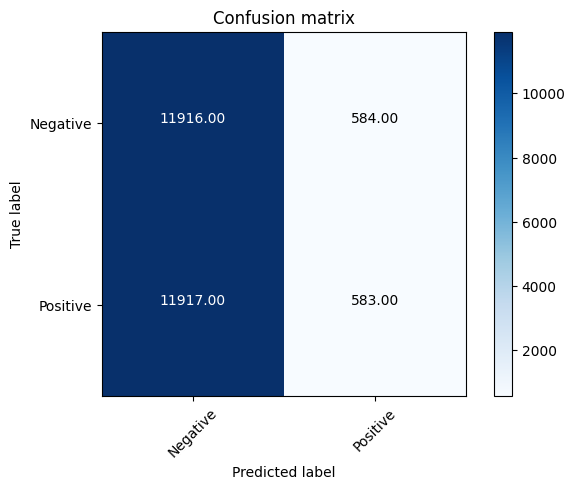

In [ ]:
if __name__ == "__main__":
    # 设置模型参数
    vocab_size = len(vocab)
    embed_dim = 50
    num_classes = 2
    max_seq_length = 100
    device = torch.device('cpu')

    # 实例化模型并移动到对应的设备
    model = TextCNN(vocab_size, embed_dim, num_classes, max_seq_length).to(device)

    # 训练模型
    num_epochs = 3
    train(model, train_loader, criterion, optimizer, num_epochs, device)

    # 交叉验证
    cross_validate(model, train_dataset, num_folds=5)

    # 在测试集上评估模型
    test_accuracy = evaluate_model(model, test_loader)
    print(f'Test Accuracy: {test_accuracy:.4f}')

    # 生成混淆矩阵并绘制
    true_labels, predictions = get_predictions(model, test_loader)
    cm = confusion_matrix(true_labels, predictions)
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

In [ ]:
def get_predictions(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())  # Store predictions
            true_labels.extend(labels.cpu().numpy())     # Store true labels

    return true_labels, predictions
